In [1]:
import tensorly as tl
import tensorly.tenalg as tg
import numpy as np
from numpy.linalg import norm
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#return matrix W with each column normalized
def get_Wbar(W):
    return W@np.diag(1/norm(W, axis = 0))
    
#return tensor T with components W, note we use two homogeneous parameterization
def get_tensor(W):
    Wbar = get_Wbar(W)
    T = tl.cp_to_tensor((None, [W,W,Wbar,Wbar]))
    return T

#return the 1/2||T-T*||_F^2
def get_loss(Tstar, W):
    T = get_tensor(W)
    loss = 0.5*(norm(Tstar - T))**2
    return loss

#return the gradient
def get_gradient(Tstar, T, W, Wbar):
    term1 = 4*tl.unfold(T-Tstar, 0)@(tl.kr([Wbar, Wbar, W]))
    term2 = 2*W@tl.diag(tl.tensor_to_vec(T-Tstar)@(tl.kr([Wbar]*4)))
    return (term1-term2)

#return the correlation between the residual and the basis directions
def get_correlation(Tstar, T):
    return tl.tensor_to_vec(Tstar - T)@(tl.kr([np.eye(d)[:,:r]]*4))
    
#run gradient descent
def vanilla_GD(Tstar, W, saddles, eta, num_iter, loss_list, correlation_list, distance_list, COMPUTE_DISTANCE):
    for i in range(num_iter):
        Wbar = W@np.diag(1/norm(W, axis = 0))
        T = tl.cp_to_tensor((None, [W,W,Wbar,Wbar]))
        loss = 0.5*(norm(Tstar - T))**2
        correlation = get_correlation(Tstar, T)
            
        correlation_list.append(correlation)
        loss_list.append(loss)
        
        if COMPUTE_DISTANCE:
            distance = np.min([norm(T-saddles[i]) for i in range(len(saddles))])
            distance_list.append(distance)
            
        
        if i%100==0:
            if orthogonal:
                print("iter#{}, loss: {}, correlation: {}".format(i, loss, correlation))
            else:
                print("iter#{}, loss: {}".format(i, loss))
        W_norm_list.append(norm(W,axis = 0))
        W_list.append(W.copy())
        gradient = get_gradient(Tstar, T, W, Wbar)
        W -= eta*gradient
            
    return W, T

#return the component that has best correlation with residual R
def get_best_correlation(R, eta, num_iter):
    V = np.random.randn(d,m)
    Vbar = V@np.diag(1/norm(V, axis = 0))
    for i in range(num_iter):
        V = Vbar + eta*tl.unfold(R, 0)@(tl.kr([Vbar]*3))
        Vbar = V@np.diag(1/norm(V, axis = 0))
        
    corr = tl.tensor_to_vec(R)@(tl.kr([Vbar]*4))
    return Vbar[:, np.argmax(corr)].reshape((-1,1))

#greedy low rank learning procedure
def greedy_low_rank(Tstar, W, saddles, eta, num_iter, loss_list1, correlation_list, distance_list):
    for s in range(r):
        if s==0:
            W = init*get_best_correlation(Tstar, eta, num_iter)
        else:
            W = np.hstack((W, init*get_best_correlation(Tstar - T, eta, num_iter*(s+1))))

        W, T = vanilla_GD(Tstar, W, saddles, eta, (s+1)*num_iter, loss_list1, correlation_list, distance_list, COMPUTE_DISTANCE = False)
        saddles.append(T)

In [3]:
#gradient descent parameters
d = 10
r = 5
m = 1000
eta = 0.3
init = 1e-100
num_iter = 3000
orthogonal = False

#construct the ground truth tensor 
if orthogonal:
    a = 1.2**np.array([1,2,3,4,5])
    a = np.sort((a))[::-1]
    Wstar = np.eye(d)[:,:r]@(np.diag(a))**0.25
else:
    Wstar = np.random.randn(d,r)
    #Wstar = Wstar@np.diag(1/norm(Wstar, axis = 0))


#ground truth tensor for non-orthogonal tensor decomposition
Wstar = np.array([[-0.79037225,  0.07005099,  0.58095469, -0.52595503,  0.60099897],
       [-1.52206411,  0.36191364,  1.34708127, -0.56571125, -0.29377751],
       [-0.23031446, -1.41921319, -0.37373797, -1.02211438,  0.71801088],
       [-0.93549671, -1.47881807, -1.19584746,  0.06290099, -0.81607334],
       [-0.54248052, -1.30165582,  0.38818195,  0.46262811, -0.32395366],
       [-0.74425509, -0.96664858,  1.89480584, -1.37132789, -1.6820107 ],
       [ 0.46299708,  0.54387881, -0.03406488, -0.89315403, -0.18024349],
       [-0.65469063,  0.03436177, -0.190509  , -0.30818727, -0.12000346],
       [-2.22264477,  1.17140469, -0.63276744, -0.15521572, -1.45851107],
       [ 1.28068789,  0.98506927,  0.5471856 , -0.20988675,  1.28894468]])

#normalize the ground truth tensor
Tstar = tl.cp_to_tensor((None, [Wstar]*4))
Tstar = Tstar/norm(Tstar)

#initialize our model
W = np.random.randn(d,m)
W = init*get_Wbar(W)

'''
big_loss = []
big_correlation = []
W_norm_list = []
W_list = []

for s in range(5):
    W = np.random.randn(d,m)
    Wbar = get_Wbar(W)
    W = init*Wbar
    
    loss_list = []
    reg_loss_list = []
    correlation_list = []
    reinit = np.array([0]*m) # 0 means reinitialized, 1 means passed the test
    distance_list = []
    saddles = [0*Tstar]

    #run the algorithm
    vanilla_GD(Tstar, W, saddles, eta, lmd, num_iter, loss_list, reg_loss_list, correlation_list, distance_list, COMPUTE_DISTANCE = False)
    #our_algo(Tstar, W, eta, lmd, num_iter, delta1, gamma, phase2_over_phase1, epochs, loss_list, reg_loss_list, correlation_list)
    
    big_loss.append(loss_list)
    big_correlation.append(correlation_list)
'''

loss_list = []
correlation_list = []
distance_list = []
saddles = [0*Tstar]
W_norm_list = []
W_list = []
    
loss_list1 = []
#run greedy low-rank learning to get the saddles
greedy_low_rank(Tstar, W, saddles, eta, num_iter, loss_list1, correlation_list, distance_list)

#run vanilla GD and compute the distance to saddles 
loss_list2 = []
W = np.random.randn(d,m)
W = init*get_Wbar(W)
W_norm_list = []
W_list = []

vanilla_GD(Tstar, W, saddles, eta, num_iter, loss_list2, correlation_list, distance_list, COMPUTE_DISTANCE = True)

iter#0, loss: 0.5
iter#100, loss: 0.5
iter#200, loss: 0.5
iter#300, loss: 0.5
iter#400, loss: 0.5
iter#500, loss: 0.5
iter#600, loss: 0.19241915667438822
iter#700, loss: 0.1924189399003668
iter#800, loss: 0.1924189399003668
iter#900, loss: 0.1924189399003668
iter#1000, loss: 0.1924189399003668
iter#1100, loss: 0.1924189399003668
iter#1200, loss: 0.1924189399003668
iter#1300, loss: 0.1924189399003668
iter#1400, loss: 0.1924189399003668
iter#1500, loss: 0.1924189399003668
iter#1600, loss: 0.1924189399003668
iter#1700, loss: 0.1924189399003668
iter#1800, loss: 0.1924189399003668
iter#1900, loss: 0.1924189399003668
iter#2000, loss: 0.1924189399003668
iter#2100, loss: 0.1924189399003668
iter#2200, loss: 0.1924189399003668
iter#2300, loss: 0.1924189399003668
iter#2400, loss: 0.1924189399003668
iter#2500, loss: 0.1924189399003668
iter#2600, loss: 0.1924189399003668
iter#2700, loss: 0.1924189399003668
iter#2800, loss: 0.1924189399003668
iter#2900, loss: 0.1924189399003668
iter#0, loss: 0.19241

KeyboardInterrupt: 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


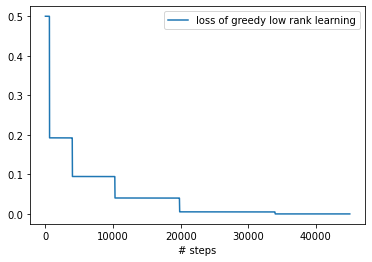

In [7]:
plt.plot(loss_list1[:], label = "loss of greedy low rank learning")
plt.legend()
plt.xlabel('# steps')
plt.savefig('greedy_loss.eps')

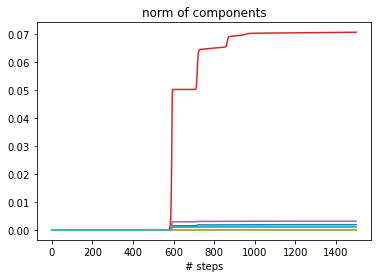

In [6]:
end = 1500
for i in range(10):
    plt.plot(np.array(W_norm_list)[:end,i])
plt.title('norm of components')
plt.xlabel('# steps')
plt.savefig('norm_growth.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


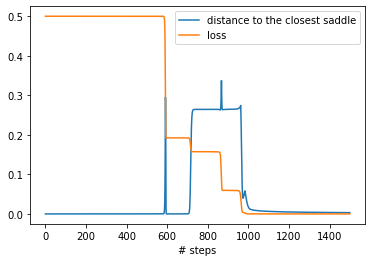

In [4]:
end = 1500
plt.plot(distance_list[:end], label = "distance to the closest saddle")
plt.plot(loss_list2[:end], label = "loss")
plt.xlabel('# steps')
plt.legend()
plt.savefig("saddle_distance.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


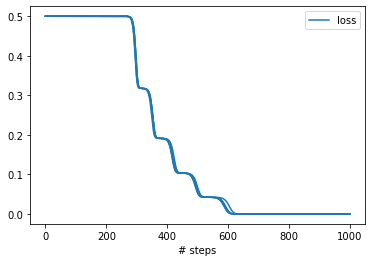

In [57]:
for s in range(5):
    if s<4:
        plt.plot(big_loss[s][:1000], color = 'tab:blue')
    else:
        plt.plot(big_loss[s][:1000], label = "loss", color = 'tab:blue')

plt.legend()
plt.xlabel('# steps')
plt.savefig("loss.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


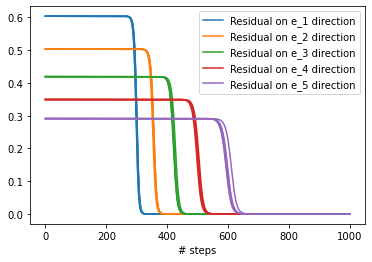

In [58]:
color_list = {0: 'tab:blue', 1: 'tab:orange', 2:'tab:green', 3:'tab:red', 4:'tab:purple'}
for i in range(r):
    for s in range(5):
        if s < 4:
            plt.plot(np.array(big_correlation[s])[:1000,i], color = color_list[i])
        else:
            plt.plot(np.array(big_correlation[s])[:1000,i], label = "Residual on e_{} direction".format(i+1), color = color_list[i])
    
plt.legend()
plt.xlabel('# steps')
plt.savefig("corr.eps")